<a href="https://colab.research.google.com/github/rrenatovich/deep_learning/blob/main/Task_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек и функций

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, auc, classification_report

In [2]:
def plot_training_curves(history):

  tr_acc = history.history['accuracy']
  tr_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]
  epochs = [i+1 for i in range(len(tr_acc))] # количество эпох обучения
  loss_label = f'best epoch = {str(index_loss + 1)}'
  acc_label = f'best epoch = {str(index_acc + 1)}'

  # Plot training history
  plt.figure(figsize= (12, 5))
  plt.style.use('fivethirtyeight')

  plt.subplot(1, 2, 1)
  plt.plot(epochs, tr_loss, 'r', label='Ошибка обучения')
  plt.plot(epochs, val_loss, 'g', label='Ошибка валидации')
  plt.scatter(index_loss + 1, val_lowest, s=150, c= 'blue', label=loss_label)
  plt.title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение ошибки', fontsize=12)
  plt.legend(fontsize=12)

  plt.subplot(1, 2, 2)
  plt.plot(epochs, tr_acc, 'r', label='Точность обучения')
  plt.plot(epochs, val_acc, 'g', label='Точность валидации')
  plt.scatter(index_acc + 1 , acc_highest, s=150, c= 'blue', label=acc_label)
  plt.title('Точность при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение точности', fontsize=12)
  plt.legend(fontsize=12)

  plt.tight_layout
  plt.show()

  return

def generate_preformance_scores(y_true, y_pred, y_probabilities):

  model_accuracy = balanced_accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                y_pred,
                                                                                average="weighted", zero_division=0)
  model_roc_auc = roc_auc_score(y_true, y_probabilities, multi_class="ovr")

  print(f'Accuracy Score:\t\t{model_accuracy:.4f}')
  print(f'Precision_score:\t{model_precision:.4f}')
  print(f'Recall_score:\t\t{model_recall:.4f}')
  print(f'F1_score:\t\t{model_f1:.4f}')
  print(f'AUC Score:\t\t{model_roc_auc:.4f}')

  return

def plot_roc_curve(y_test, y_prob, figsize=(5,5)):

  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)

  fig, ax = plt.subplots(figsize=figsize)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.set_xlim([-0.01, 1.0])
  ax.set_ylim([0.0, 1.01])
  ax.set_xlabel('False Positive Rate', fontsize=12)
  ax.set_ylabel('True Positive Rate', fontsize=12)
  ax.set_title("График ROC-кривой", fontsize=14, fontweight="bold")
  ax.plot(fpr, tpr, label='AUC = %0.3f' % (roc_auc))
  ax.legend(loc="best")
  ax.grid(alpha=.4)
  plt.show()

# Чтение данных

In [60]:
df = pd.read_excel("https://docs.google.com/spreadsheets/d/e/2PACX-1vQFF3mjUeHP3CWhZqdeVInESL3eFN72K1urhfuBWoiG9bXwZqRt-7Cjaf2Ls5fltDXd_D7nk75SLcPC/pub?output=xlsx")
df.head()

,text,sentiment
0,"My daughter liked it but I was aghast, that a ...",neg
1,I... No words. No words can describe this. I w...,neg
2,this film is basically a poor take on the old ...,neg
3,"This is a terrible movie, and I'm not even sur...",neg
4,First of all this movie is a piece of reality ...,pos


In [61]:
df = df.iloc[0:5000]

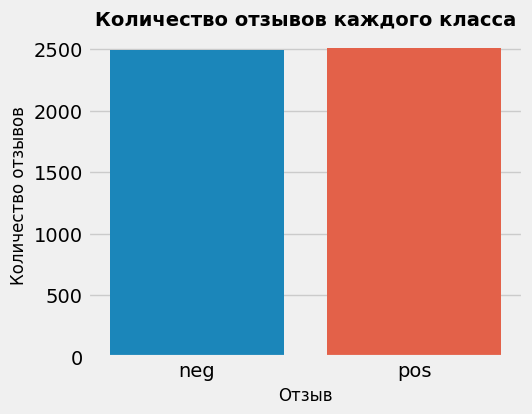

In [62]:
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='sentiment')

plt.xlabel('Отзыв', fontsize=12)
plt.ylabel('Количество отзывов', fontsize=12)
plt.title('Количество отзывов каждого класса', fontsize=14, fontweight="bold");

# Предобработка данных




Удалим из текста перенос строки, пунктуацию, и приведем все буквы к нижнему регистру

In [63]:
def unify_fragment(elem):
  elem = re.sub(r'[^\w\s]', ' ', elem)
  elem = re.sub(r'\n', ' ', elem)
  elem = elem.lower()
  elem = ' '.join(elem.split())

  return elem

In [64]:
df["text"] = df["text"].apply(unify_fragment)

In [65]:
encoder = LabelEncoder()
df["label"] = encoder.fit_transform(df["sentiment"])

In [66]:
df

,text,sentiment,label
0,my daughter liked it but i was aghast that a c...,neg,0
1,i no words no words can describe this i will t...,neg,0
2,this film is basically a poor take on the old ...,neg,0
3,this is a terrible movie and i m not even sure...,neg,0
4,first of all this movie is a piece of reality ...,pos,1
...,...,...,...
4995,this documentary sheds absolutely no light on ...,neg,0
4996,although the plot of this film is a bit far fe...,pos,1
4997,the detective story is not typical for the mat...,pos,1
4998,i am a huge fan of harald zwart and i just kne...,pos,1


# Получим токенизатор

In [67]:
def get_max_word_count(data):
  max = 0
  for elem in data:
    if (len(elem.split()) > max):
      max = len(elem.split())

  return max

In [68]:
max_length = get_max_word_count(df["text"])
max_length

1117

In [69]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [70]:
sentences = df["text"]

In [71]:
input_ids = []
attention_masks = []
max_length = get_max_word_count(df["text"])

if (max_length > 512):
  max_length = 124

for sent in sentences:
  bert_inp = tokenizer.encode_plus(sent,
                                   add_special_tokens=True,
                                   max_length=124,
                                   pad_to_max_length=True,
                                   truncation=True,
                                   return_attention_mask=True)

  input_ids.append(bert_inp['input_ids'])
  attention_masks.append(bert_inp['attention_mask'])

input_ids = np.asarray(input_ids)
attention_masks = np.array(attention_masks)
target = np.array(pd.get_dummies(df['label']))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [72]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# Деление на выборки

In [73]:
X_train, X_test, y_train, y_test, train_mask, test_mask = train_test_split(input_ids, target, attention_masks, test_size=0.1, random_state = 47)
X_train, X_val, y_train, y_val, train_mask, val_mask = train_test_split(X_train, y_train, train_mask, test_size=0.1, random_state = 47)

In [74]:
y_tested = np.argmax(y_test, axis=1)

In [75]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер тренировочной выборки: (4050, 124)
Размер валидационной выборки: (450, 124)
Размер тестовой выборки: (500, 124)


# Создание моделей BERT

## Bert transfer learning

In [76]:
def create_model(model):
    input_ids = keras.Input(shape=(max_length,), dtype='int32')
    attention_masks = keras.Input(shape=(max_length,), dtype='int32')

    output = model(input_ids, attention_masks)
    encoder_output = output[0]
    pooler_output = output[1]
    output = keras.layers.Concatenate()([encoder_output[:,0,:], pooler_output])

    output = keras.layers.Dense(32, activation='relu')(output)
    output = keras.layers.Dropout(0.25)(output)
    output = keras.layers.Dense(8, activation='relu')(output)
    output = keras.layers.Dense(df['sentiment'].nunique(), activation='softmax')(output)
    model = keras.models.Model(inputs=[input_ids, attention_masks],
                                  outputs=output)


    for layer in model.layers[:5]:
        layer.trainable = False
    return model

In [77]:
model = create_model(bert_model)

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_5[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_6[0][0]']             
                             hidden_state=(None, 124, 7                                           
                             68),                                                           

In [78]:
history = model.fit([X_train, train_mask],
                    y_train,
                    batch_size=64,
                    epochs=6,
                    validation_data=([X_val, val_mask], y_val))

Epoch 1/6
64/64 [==============================] - 55s 661ms/step - loss: 0.6558 - accuracy: 0.6079 - val_loss: 0.6126 - val_accuracy: 0.6800
Epoch 2/6
64/64 [==============================] - 39s 607ms/step - loss: 0.5724 - accuracy: 0.7111 - val_loss: 0.5179 - val_accuracy: 0.7467
Epoch 3/6
64/64 [==============================] - 39s 609ms/step - loss: 0.5403 - accuracy: 0.7341 - val_loss: 0.5024 - val_accuracy: 0.7711
Epoch 4/6
64/64 [==============================] - 40s 632ms/step - loss: 0.5146 - accuracy: 0.7430 - val_loss: 0.4918 - val_accuracy: 0.7644
Epoch 5/6
64/64 [==============================] - 40s 631ms/step - loss: 0.5012 - accuracy: 0.7600 - val_loss: 0.4682 - val_accuracy: 0.7689
Epoch 6/6
64/64 [==============================] - 40s 632ms/step - loss: 0.4899 - accuracy: 0.7684 - val_loss: 0.4906 - val_accuracy: 0.7578


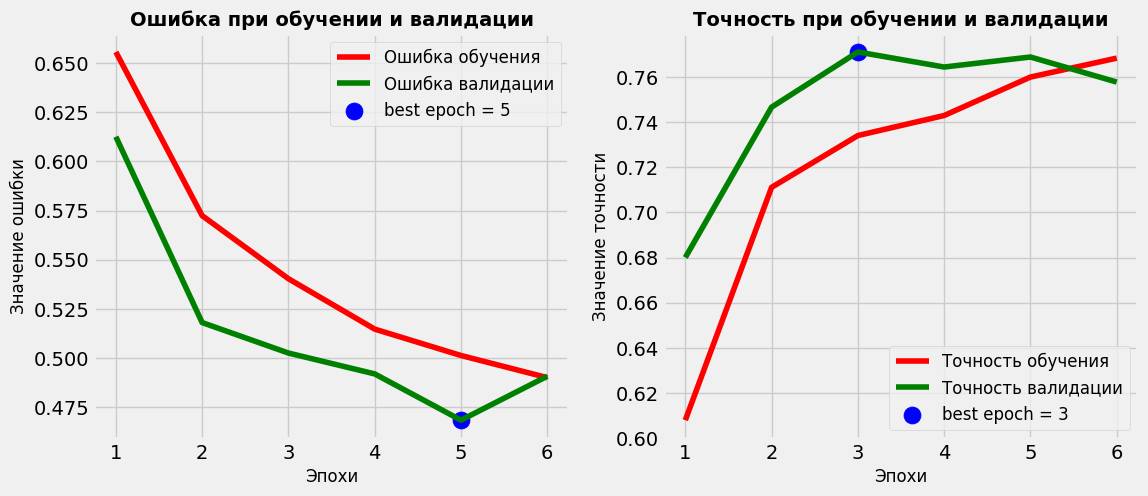

In [79]:
plot_training_curves(history)

In [80]:
y_predicted_prob = model.predict([X_test, test_mask])
y_predicted = np.argmax(y_predicted_prob, axis=1)

16/16 [==============================] - 7s 264ms/step


In [81]:
y_prob = []
for i in range(len(y_predicted_prob)):
  y_prob.append(y_predicted_prob[i][1])

In [82]:
generate_preformance_scores(y_tested, y_predicted, y_prob)

Accuracy Score:		0.7572
Precision_score:	0.7615
Recall_score:		0.7540
F1_score:		0.7536
AUC Score:		0.8451


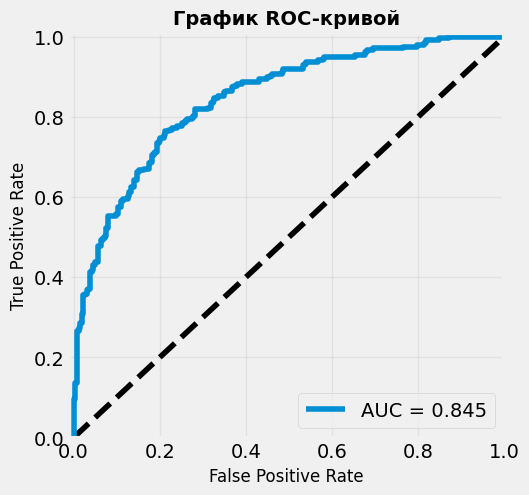

In [83]:
plot_roc_curve(y_tested, y_prob)

## Bert fine tuning

In [24]:
def create_model(model):
    input_ids = keras.Input(shape=(max_length,), dtype='int32')
    attention_masks = keras.Input(shape=(max_length,), dtype='int32')

    output = model(input_ids, attention_masks)
    encoder_output = output[0]
    pooler_output = output[1]
    output = keras.layers.Concatenate()([encoder_output[:,0,:], pooler_output])

    output = keras.layers.Dense(16, activation='relu')(output)
    output = keras.layers.Dropout(0.25)(output)
    output = keras.layers.Dense(8, activation='relu')(output)
    output = keras.layers.Dense(df['sentiment'].nunique(), activation='softmax')(output)
    model = keras.models.Model(inputs=[input_ids, attention_masks],
                                  outputs=output)

    return model

In [25]:
model = create_model(bert_model)

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 124)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_3[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_4[0][0]']             
                             hidden_state=(None, 124, 7                                           
                             68),                                                           

In [26]:
history = model.fit([X_train, train_mask],
                    y_train,
                    batch_size=32,
                    epochs=6,
                    validation_data=([X_val, val_mask], y_val))

Epoch 1/6
127/127 [==============================] - 65s 342ms/step - loss: 0.6741 - accuracy: 0.5877 - val_loss: 0.6629 - val_accuracy: 0.5844
Epoch 2/6
127/127 [==============================] - 41s 323ms/step - loss: 0.6038 - accuracy: 0.6602 - val_loss: 0.5586 - val_accuracy: 0.7378
Epoch 3/6
127/127 [==============================] - 42s 330ms/step - loss: 0.5616 - accuracy: 0.6889 - val_loss: 0.5144 - val_accuracy: 0.7556
Epoch 4/6
127/127 [==============================] - 41s 321ms/step - loss: 0.5621 - accuracy: 0.6837 - val_loss: 0.5616 - val_accuracy: 0.7089
Epoch 5/6
127/127 [==============================] - 42s 330ms/step - loss: 0.5411 - accuracy: 0.6958 - val_loss: 0.5030 - val_accuracy: 0.7556
Epoch 6/6
127/127 [==============================] - 42s 331ms/step - loss: 0.5442 - accuracy: 0.6975 - val_loss: 0.4841 - val_accuracy: 0.7622


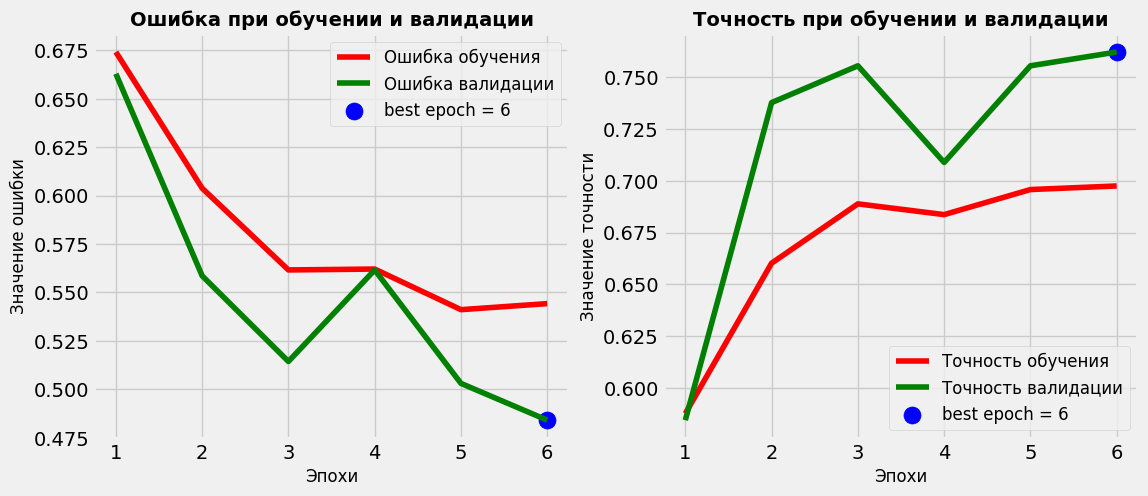

In [27]:
plot_training_curves(history)

In [28]:
y_predicted_prob = model.predict([X_test, test_mask]) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1)

16/16 [==============================] - 8s 260ms/step


In [29]:
y_prob = []
for i in range(len(y_predicted_prob)):
  y_prob.append(y_predicted_prob[i][1])

In [30]:
generate_preformance_scores(y_tested, y_predicted, y_prob)

Accuracy Score:		0.7631
Precision_score:	0.7737
Recall_score:		0.7580
F1_score:		0.7565
AUC Score:		0.8493


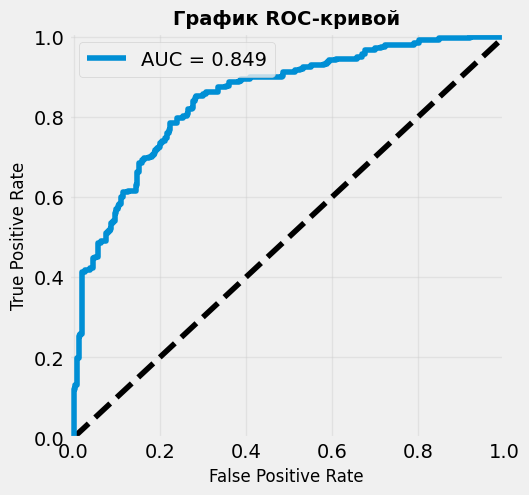

In [31]:
plot_roc_curve(y_tested, y_prob)

# Чтение данных

In [32]:
df = pd.read_excel("https://docs.google.com/spreadsheets/d/e/2PACX-1vQFF3mjUeHP3CWhZqdeVInESL3eFN72K1urhfuBWoiG9bXwZqRt-7Cjaf2Ls5fltDXd_D7nk75SLcPC/pub?output=xlsx")
df.head()

,text,sentiment
0,"My daughter liked it but I was aghast, that a ...",neg
1,I... No words. No words can describe this. I w...,neg
2,this film is basically a poor take on the old ...,neg
3,"This is a terrible movie, and I'm not even sur...",neg
4,First of all this movie is a piece of reality ...,pos


In [33]:
df["text"] = df["text"].apply(unify_fragment)

In [34]:
encoder = LabelEncoder()
df["label"] = encoder.fit_transform(df["sentiment"])

In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [36]:
# Создаем токенизатор и обучаем его на всех текстах
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["text"])

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.1, random_state = 47)

In [38]:
from keras.utils import to_categorical

In [39]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [40]:
y_tested = np.argmax(y_test, axis=1)

In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [42]:
# Преобразуем тексты в последовательности целых чисел
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Определяем максимальную длину последовательности
max_length = max([len(x) for x in train_sequences])

# Дополняем последовательности до максимальной длины
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

vocab_size = len(tokenizer.word_index) + 1  # Размер словаря

# Создание моделей LSTM

## LSTM

In [43]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=max_length))
model.add(keras.layers.LSTM(256, return_sequences=True))
model.add(keras.layers.LSTM(256))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(df['sentiment'].nunique(), activation='softmax'))

In [44]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2389, 256)         18886400  
                                                                 
 lstm (LSTM)                 (None, 2389, 256)         525312    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_39 (Dropout)        (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 16)                4112      
                                                                 
 dropout_40 (Dropout)        (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 8)                 1

In [45]:
history = model.fit(train_padded,
                    y_train,
                    batch_size=32,
                    epochs=6,
                    validation_split=0.1)

Epoch 1/6
633/633 [==============================] - 209s 322ms/step - loss: 0.6938 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.4956
Epoch 2/6
633/633 [==============================] - 199s 314ms/step - loss: 0.6938 - accuracy: 0.4975 - val_loss: 0.6943 - val_accuracy: 0.5164
Epoch 3/6
633/633 [==============================] - 187s 296ms/step - loss: 0.6934 - accuracy: 0.5023 - val_loss: 0.6927 - val_accuracy: 0.5160
Epoch 4/6
633/633 [==============================] - 178s 281ms/step - loss: 0.6928 - accuracy: 0.5104 - val_loss: 0.6926 - val_accuracy: 0.5160
Epoch 5/6
633/633 [==============================] - 178s 281ms/step - loss: 0.6930 - accuracy: 0.5093 - val_loss: 0.6927 - val_accuracy: 0.5160
Epoch 6/6
633/633 [==============================] - 174s 274ms/step - loss: 0.6929 - accuracy: 0.5107 - val_loss: 0.6927 - val_accuracy: 0.5160


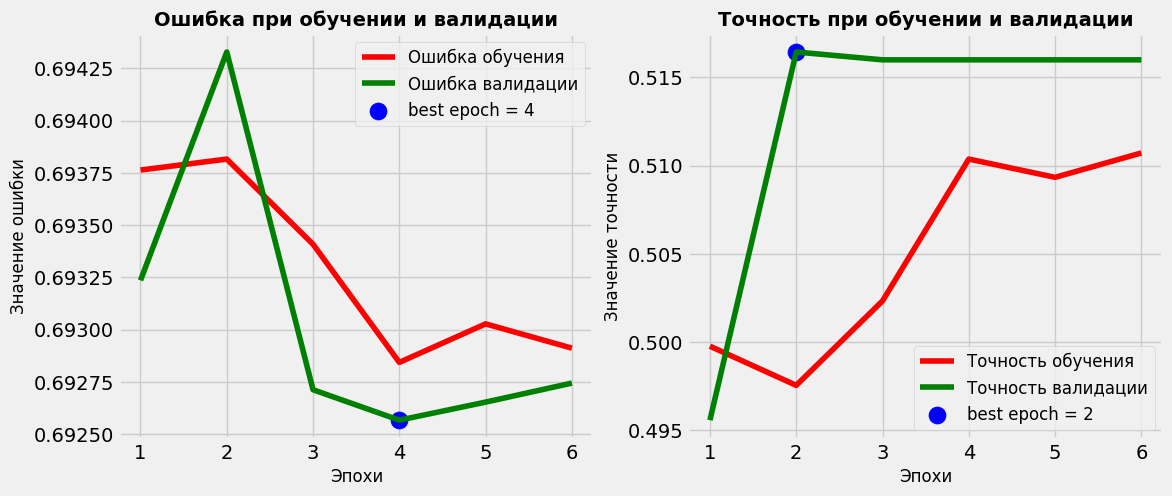

In [46]:
plot_training_curves(history)

In [47]:
y_predicted_prob = model.predict(test_padded)
y_predicted = np.argmax(y_predicted_prob, axis=1)

79/79 [==============================] - 10s 111ms/step


In [48]:
y_prob = []
for i in range(len(y_predicted_prob)):
  y_prob.append(y_predicted_prob[i][1])

In [49]:
generate_preformance_scores(y_tested, y_predicted, y_prob)

Accuracy Score:		0.5161
Precision_score:	0.5256
Recall_score:		0.5120
F1_score:		0.4636
AUC Score:		0.5161


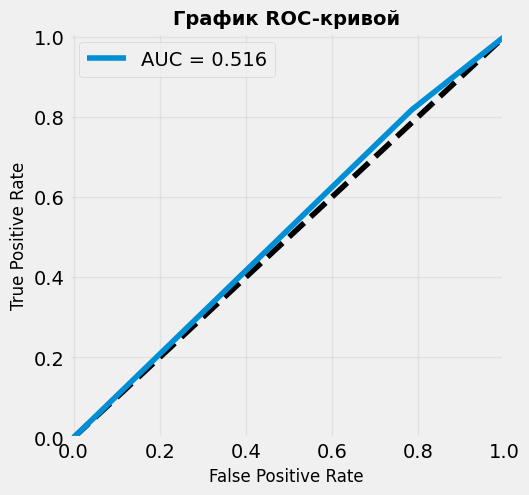

In [51]:
plot_roc_curve(y_tested, y_prob)

## Bi-LSTM

In [52]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=max_length))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(df['sentiment'].nunique(), activation='softmax'))

In [53]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2389, 256)         18886400  
                                                                 
 bidirectional (Bidirection  (None, 2389, 256)         394240    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                                 
 dense_10 (Dense)            (None, 2)                 130       
                                                                 
Total params: 19691458 (75.12 MB)
Trainable params: 19

In [54]:
history = model.fit(train_padded,
                    y_train,
                    batch_size=64,
                    epochs=6,
                    validation_split=0.1)

Epoch 1/6
317/317 [==============================] - 180s 544ms/step - loss: 0.5785 - accuracy: 0.6784 - val_loss: 0.4046 - val_accuracy: 0.8311
Epoch 2/6
317/317 [==============================] - 174s 548ms/step - loss: 0.3297 - accuracy: 0.8630 - val_loss: 0.3711 - val_accuracy: 0.8413
Epoch 3/6
317/317 [==============================] - 171s 538ms/step - loss: 0.1584 - accuracy: 0.9433 - val_loss: 0.3586 - val_accuracy: 0.8791
Epoch 4/6
317/317 [==============================] - 170s 535ms/step - loss: 0.0866 - accuracy: 0.9698 - val_loss: 0.3508 - val_accuracy: 0.8938
Epoch 5/6
317/317 [==============================] - 168s 529ms/step - loss: 0.0488 - accuracy: 0.9845 - val_loss: 0.3523 - val_accuracy: 0.8924
Epoch 6/6
317/317 [==============================] - 166s 525ms/step - loss: 0.0291 - accuracy: 0.9910 - val_loss: 0.4289 - val_accuracy: 0.8698


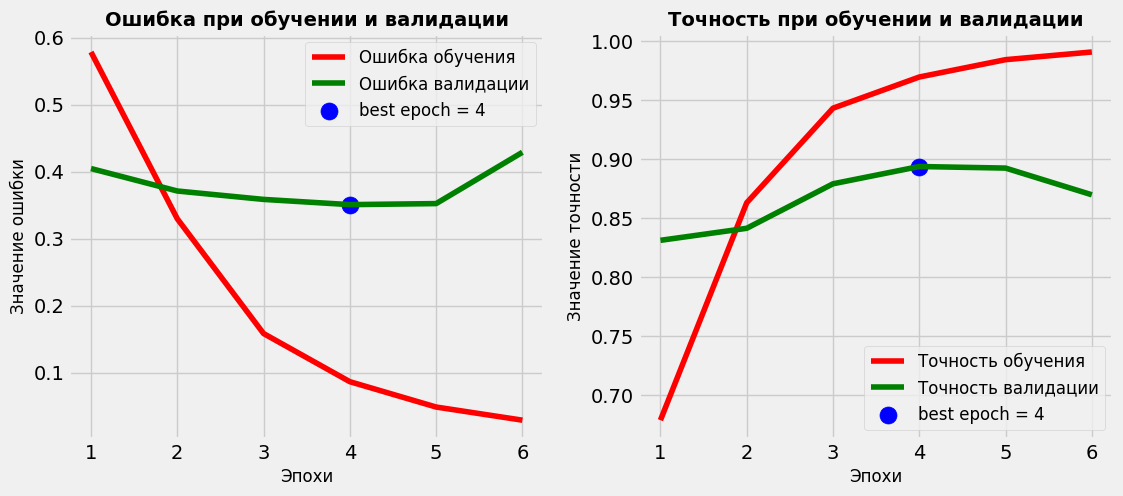

In [55]:
plot_training_curves(history)

In [56]:
y_predicted_prob = model.predict(test_padded)
y_predicted = np.argmax(y_predicted_prob, axis=1)

79/79 [==============================] - 12s 128ms/step


In [57]:
y_prob = []
for i in range(len(y_predicted_prob)):
  y_prob.append(y_predicted_prob[i][1])

In [58]:
generate_preformance_scores(y_tested, y_predicted, y_prob)

Accuracy Score:		0.8699
Precision_score:	0.8768
Recall_score:		0.8708
F1_score:		0.8701
AUC Score:		0.9527


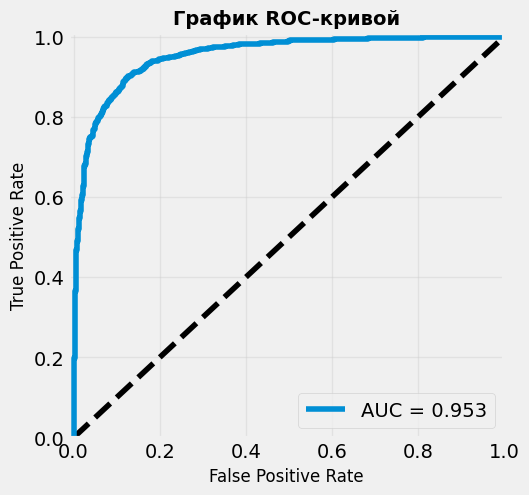

In [59]:
plot_roc_curve(y_tested, y_prob)